In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import io as spio
from tqdm import tqdm
import cv2
from sklearn import metrics


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split Data

In [2]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ('\nElapsed time is ')
        print (str(time.time() - startTime_for_tictoc))
        print('seconds.\n')
    else:
        print ('\nToc: start time not set\n')

In [3]:
data= sio.loadmat('/Users/fernanda/Documents/Tese_Mestrado/GitHub/Plastic-Strain-Predictions/data/Sample_1/RDM_Sample_1.mat')
angles= data['RDM']['angles'][0][0]
Enn= data['RDM']['Strains'][0][0][0][0][5]
Etn= data['RDM']['Strains'][0][0][0][0][4]
Ett= data['RDM']['Strains'][0][0][0][0][3]
CM= data['RDM']['CM'][0][0]

indPred= CM==1
wndSize= 25
n,m = angles.shape

print('n=', n , 'm=', m )

stride= int((wndSize-1)/2)
ncases= sum(sum(CM[stride:n-stride,stride:m-stride]==1))

Y= np.zeros((ncases,5))
X0= np.zeros((ncases, wndSize**2))
X1= np.zeros((ncases,1))

cnt=0
for i in range(0+stride,n-stride):
  for j in range(0+stride,m-stride):
    if CM[i,j] == 1:
      indX= range(i-stride,i+stride+1)
      indY= range(j-stride,j+stride+1)
      Maux = angles[indX, :][:, indY]
      row= [Enn[i,j], Etn[i,j], Ett[i,j],i,j]
      Y[cnt,:]= row
      X0[cnt,:]= Maux.flatten()
      X1[cnt,:]= angles[i,j]
      cnt= cnt+1
      prog=cnt/ncases*100

n= 199 m= 210


In [4]:
Y1=Y[:,1]

df = pd.DataFrame({'Angles': X1.flatten()}) 
df['Enn'] = Y[:,0].flatten()
df['Etn'] = Y[:,1].flatten()
df['Ett'] = Y[:,2].flatten()
df['i'] = Y[:,3].flatten()
df['j'] = Y[:,4].flatten()

In [5]:
df

,Angles,Enn,Etn,Ett,i,j
0,1.265090,-0.019728,-0.006153,0.047145,12.0,35.0
1,1.265090,-0.021315,-0.008860,0.044652,12.0,36.0
2,1.265090,-0.023895,-0.011431,0.041400,12.0,37.0
3,1.268809,-0.026060,-0.013764,0.039412,12.0,38.0
4,1.286458,-0.027144,-0.014716,0.038354,12.0,39.0
...,...,...,...,...,...,...
10660,-0.899112,0.005716,0.009976,0.001424,186.0,162.0
10661,-0.899112,0.005706,0.012690,0.002096,186.0,163.0
10662,-0.927225,0.004249,0.014915,0.003026,186.0,164.0
10663,-0.960139,0.001893,0.016678,0.004734,186.0,165.0


# Data Augmentation

## Added noise

In [6]:
import numpy as np

def augment_data(angles_arr, enn_arr, etn_arr, ett_arr, noise_stddev, noise_prob):
    angle_aug = []
    enn_aug = []
    etn_aug = []
    ett_aug = []
    for angle, enn, etn, ett in zip(angles_arr, enn_arr, etn_arr, ett_arr):
        noise = np.random.normal(0, noise_stddev)
        augmented_angle_ = angle + noise
        augmented_enn_ = enn + noise
        augmented_etn_ = etn + noise
        augmented_ett_ = ett + noise
        
        angle_aug.append(angle)
        enn_aug.append(enn)
        etn_aug.append(etn)
        ett_aug.append(ett)
        
        if np.random.rand() < noise_prob:
            angle_aug.append(augmented_angle_)
            enn_aug.append(augmented_enn_)
            etn_aug.append(augmented_etn_)
            ett_aug.append(augmented_ett_)

    return np.array(angle_aug), np.array(enn_aug), np.array(etn_aug), np.array(ett_aug)

X = X0
y = df.iloc[:,1:4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Load your input and target data
angle_data = X_train
enn_data = y_train['Enn']
etn_data = y_train['Etn']
ett_data = y_train['Ett']

# Generate augmented input and target data
augmented_angle_data, augmented_enn_data, augmented_etn_data, augmented_ett_data = augment_data(angle_data, enn_data, etn_data, ett_data, 0.2, 0.3)

X_train_aug = augmented_angle_data
y_train_aug = pd.DataFrame(list(zip(augmented_enn_data,augmented_etn_data,augmented_ett_data)),columns=['Enn','Etn','Ett'])

print(X_train.shape, X_train_aug.shape)
print(y_train.shape, y_train_aug.shape)


(7465, 625) (9693, 625)
(7465, 3) (9693, 3)


# Model

In [7]:
# Scaling not augmented data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print(X_train.shape)

X_test = scaler.transform(X_test)
print(X_test.shape)

# Scaling augmented data
scaler_aug = StandardScaler()
X_train_aug = scaler_aug.fit_transform(X_train_aug)
print(X_train_aug.shape)

X_test_aug = scaler_aug.transform(X_train_aug)

(7465, 625)
(3200, 625)
(9693, 625)


In [8]:

# Import necessary libraries
from sklearn.pipeline import Pipeline
from tensorflow import keras
import numpy as np


model = keras.Sequential([
    keras.layers.Flatten(input_shape=(625,)),  
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dense(3)
])

model_aug = keras.Sequential([
    keras.layers.Flatten(input_shape=(625,)),  
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.Dense(256, activation='relu'),  
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3)  
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model_aug.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
batch_ = 64
epochs_ = 200
history = model.fit(X_train, y_train, epochs=epochs_, batch_size=batch_, validation_split=0.2, verbose=2)


Epoch 1/200


2023-09-13 18:14:43.674354: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


94/94 - 2s - loss: 0.0424 - val_loss: 0.0043 - 2s/epoch - 23ms/step
Epoch 2/200
94/94 - 1s - loss: 0.0023 - val_loss: 0.0023 - 646ms/epoch - 7ms/step
Epoch 3/200
94/94 - 1s - loss: 0.0011 - val_loss: 0.0018 - 589ms/epoch - 6ms/step
Epoch 4/200
94/94 - 1s - loss: 7.0124e-04 - val_loss: 0.0016 - 574ms/epoch - 6ms/step
Epoch 5/200
94/94 - 1s - loss: 4.8101e-04 - val_loss: 0.0014 - 618ms/epoch - 7ms/step
Epoch 6/200
94/94 - 1s - loss: 3.4532e-04 - val_loss: 0.0013 - 638ms/epoch - 7ms/step
Epoch 7/200
94/94 - 1s - loss: 2.6463e-04 - val_loss: 0.0012 - 586ms/epoch - 6ms/step
Epoch 8/200
94/94 - 1s - loss: 2.0882e-04 - val_loss: 0.0012 - 642ms/epoch - 7ms/step
Epoch 9/200
94/94 - 1s - loss: 1.6955e-04 - val_loss: 0.0012 - 631ms/epoch - 7ms/step
Epoch 10/200
94/94 - 1s - loss: 1.3872e-04 - val_loss: 0.0011 - 689ms/epoch - 7ms/step
Epoch 11/200
94/94 - 1s - loss: 1.2275e-04 - val_loss: 0.0011 - 616ms/epoch - 7ms/step
Epoch 12/200
94/94 - 1s - loss: 1.0487e-04 - val_loss: 0.0011 - 773ms/epoch - 

In [9]:
history_aug = model_aug.fit(X_train_aug, y_train_aug, epochs=epochs_, batch_size=batch_, validation_split=0.2, verbose=2)

Epoch 1/200
122/122 - 1s - loss: 0.0351 - val_loss: 0.0109 - 1s/epoch - 11ms/step
Epoch 2/200
122/122 - 1s - loss: 0.0071 - val_loss: 0.0086 - 773ms/epoch - 6ms/step
Epoch 3/200
122/122 - 1s - loss: 0.0049 - val_loss: 0.0072 - 786ms/epoch - 6ms/step
Epoch 4/200
122/122 - 1s - loss: 0.0036 - val_loss: 0.0061 - 854ms/epoch - 7ms/step
Epoch 5/200
122/122 - 1s - loss: 0.0029 - val_loss: 0.0058 - 897ms/epoch - 7ms/step
Epoch 6/200
122/122 - 1s - loss: 0.0022 - val_loss: 0.0055 - 733ms/epoch - 6ms/step
Epoch 7/200
122/122 - 1s - loss: 0.0022 - val_loss: 0.0050 - 855ms/epoch - 7ms/step
Epoch 8/200
122/122 - 1s - loss: 0.0018 - val_loss: 0.0047 - 813ms/epoch - 7ms/step
Epoch 9/200
122/122 - 1s - loss: 0.0018 - val_loss: 0.0051 - 749ms/epoch - 6ms/step
Epoch 10/200
122/122 - 1s - loss: 0.0021 - val_loss: 0.0046 - 826ms/epoch - 7ms/step
Epoch 11/200
122/122 - 1s - loss: 0.0016 - val_loss: 0.0046 - 857ms/epoch - 7ms/step
Epoch 12/200
122/122 - 1s - loss: 0.0015 - val_loss: 0.0038 - 822ms/epoch - 

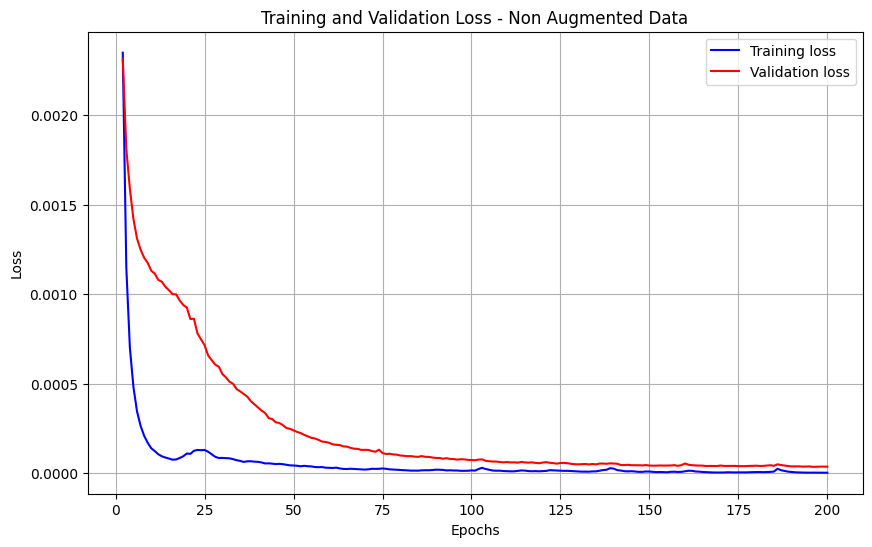

In [10]:
# Extraia os valores de loss do histórico
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crie um gráfico para visualizar as curvas de loss
epochs = range(2, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss[1:], 'b', label='Training loss')
plt.plot(epochs, val_loss[1:], 'r', label='Validation loss')
plt.title('Training and Validation Loss - Non Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


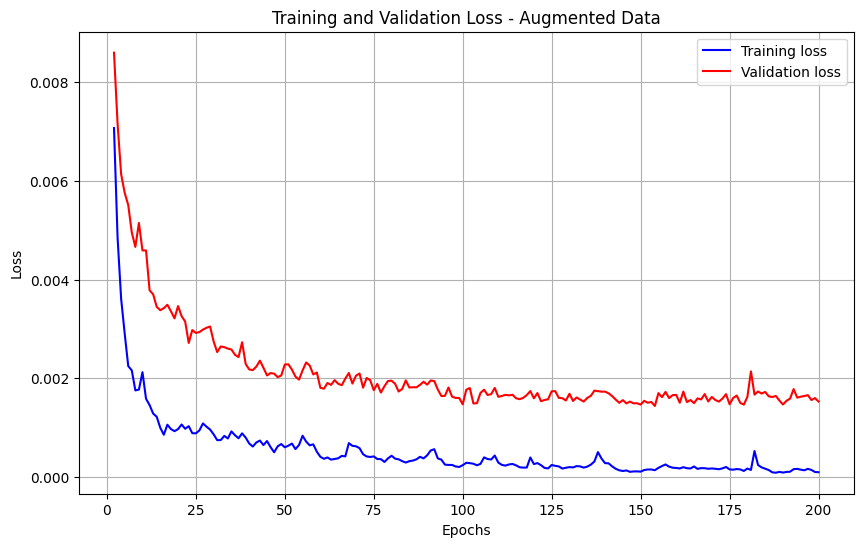

In [11]:
# Extraia os valores de loss do histórico
train_loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

# Crie um gráfico para visualizar as curvas de loss
epochs = range(2, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss[1:], 'b', label='Training loss')
plt.plot(epochs, val_loss[1:], 'r', label='Validation loss')
plt.title('Training and Validation Loss - Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
y_hat = model.predict(X_test)
print(y_hat.shape)

y_hat_aug = model_aug.predict(X_test)
print(y_hat_aug.shape)

100/100 [==============================] - 0s 2ms/step
(3200, 3)
100/100 [==============================] - 0s 901us/step
(3200, 3)


In [13]:
PredDF = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)).rename(columns={"Enn": "y1","Etn": "y2","Ett": "y3"}),
                                      pd.DataFrame(y_hat,columns=['yh1','yh2','yh3'])],axis=1)

PredDF_aug = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)).rename(columns={"Enn": "y1","Etn": "y2","Ett": "y3"}),
                                      pd.DataFrame(y_hat_aug,columns=['yh1','yh2','yh3'])],axis=1)

# Model Evaluation

## Correlation

In [14]:
PredDF.corr().iloc[:3,3:]

,yh1,yh2,yh3
y1,0.900117,-0.079535,-0.557803
y2,-0.097448,0.905631,0.150332
y3,-0.557175,0.112909,0.934418


In [15]:
PredDF_aug.corr().iloc[:3,3:]

,yh1,yh2,yh3
y1,0.596623,-0.050441,-0.369006
y2,-0.107235,0.566328,0.065903
y3,-0.407901,0.021206,0.602402


## R2

In [17]:
print('Resultados Holdout Enn')
print('')
print(metrics.r2_score(PredDF['y1'], PredDF['yh1']))
print('')
print('')
# plt.scatter(PredDF['y1'], PredDF['yh1'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()

print('Resultados Holdout Etn')
print('')
print(metrics.r2_score(PredDF['y2'], PredDF['yh2']))
print('')
print('')
# plt.scatter(PredDF['y2'], PredDF['yh2'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()

print('Resultados Holdout Ett')
print('')
print(metrics.r2_score(PredDF['y3'], PredDF['yh3']))
print('')
print('')
# plt.scatter(PredDF['y3'], PredDF['yh3'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()


print('PredDF_aug: Resultados Holdout Enn')
print('')
print(metrics.r2_score(PredDF_aug['y1'], PredDF_aug['yh1']))
print('')
print('')
# plt.scatter(PredDF_aug['y1'], PredDF_aug['yh1'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()

print('PredDF_aug: Resultados Holdout Etn')
print('')
print(metrics.r2_score(PredDF_aug['y2'], PredDF_aug['yh2']))
print('')
print('')
# plt.scatter(PredDF_aug['y2'], PredDF_aug['yh2'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()

print('PredDF_aug: Resultados Holdout Ett')
print('')
print(metrics.r2_score(PredDF_aug['y3'], PredDF_aug['yh3']))
# print('')
# print('')
# plt.scatter(PredDF_aug['y3'], PredDF_aug['yh3'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()

Resultados Holdout Enn

0.8062379068088004


Resultados Holdout Etn

0.8111099917983591


Resultados Holdout Ett

0.8660985971694749


PredDF_aug: Resultados Holdout Enn

-0.26390002239125754


PredDF_aug: Resultados Holdout Etn

-0.289175304107971


PredDF_aug: Resultados Holdout Ett

-0.12197141656335342


In [60]:
ind_tr1= y_test.Enn
ind_tr2= y_test.Etn
ind_tr3= y_test.Ett
y_test.loc[ind_tr1.index,'Enn'] = y_hat[:,0]
y_test.loc[ind_tr2.index,'Etn'] = y_hat[:,1]
y_test.loc[ind_tr3.index,'Ett'] = y_hat[:,2]

ind_tr1_aug= y_test.Enn
ind_tr2_aug= y_test.Etn
ind_tr3_aug= y_test.Ett
y_test.loc[ind_tr1_aug.index,'Enn'] = y_hat_aug[:,0]
y_test.loc[ind_tr2_aug.index,'Etn'] = y_hat_aug[:,1]
y_test.loc[ind_tr3_aug.index,'Ett'] = y_hat_aug[:,2]

In [61]:
ind_tes1= y_test.Enn
ind_tes2= y_test.Etn
ind_tes3= y_test.Ett
df.loc[ind_tes1.index,'Enn'] = y_test.Enn
df.loc[ind_tes2.index,'Etn'] = y_test.Etn
df.loc[ind_tes3.index,'Ett'] = y_test.Ett

df_aug = df
ind_tes1_aug= y_test.Enn
ind_tes2_aug= y_test.Etn
ind_tes3_aug= y_test.Ett
df_aug.loc[ind_tes1_aug.index,'Enn'] = y_test.Enn
df_aug.loc[ind_tes2_aug.index,'Etn'] = y_test.Etn
df_aug.loc[ind_tes3_aug.index,'Ett'] = y_test.Ett

In [62]:
display(df[0:15])

,Angles,Enn,Etn,Ett,i,j
0,1.313459,-0.021131,-0.005029,0.037062,17.0,34.0
1,1.313459,-0.016244,-0.003890,0.037659,17.0,35.0
2,1.272007,-0.017141,-0.007839,0.037039,17.0,36.0
3,1.272007,-0.015405,-0.004652,0.029757,17.0,37.0
4,1.272007,-0.022577,-0.014142,0.030379,17.0,38.0
5,4.405660,-0.024865,-0.016795,0.028040,17.0,39.0
6,4.405660,-0.023602,-0.016421,0.028559,17.0,40.0
7,4.403640,-0.019546,-0.016275,0.028751,17.0,41.0
8,4.403640,-0.006281,-0.012775,0.030849,17.0,42.0
9,4.403640,-0.017362,-0.016113,0.027512,17.0,43.0


In [63]:
display(df_aug[0:15])

,Angles,Enn,Etn,Ett,i,j
0,1.313459,-0.021131,-0.005029,0.037062,17.0,34.0
1,1.313459,-0.016244,-0.003890,0.037659,17.0,35.0
2,1.272007,-0.017141,-0.007839,0.037039,17.0,36.0
3,1.272007,-0.015405,-0.004652,0.029757,17.0,37.0
4,1.272007,-0.022577,-0.014142,0.030379,17.0,38.0
5,4.405660,-0.024865,-0.016795,0.028040,17.0,39.0
6,4.405660,-0.023602,-0.016421,0.028559,17.0,40.0
7,4.403640,-0.019546,-0.016275,0.028751,17.0,41.0
8,4.403640,-0.006281,-0.012775,0.030849,17.0,42.0
9,4.403640,-0.017362,-0.016113,0.027512,17.0,43.0


In [64]:
n1, m1= angles.shape
ncases1=n1*m1

print('n1=', n1,'m1=', m1)
print('ncases=',ncases1)

y_r= np.zeros((ncases1,5))
y_r.shape

cont=0
for k in range(0, n1):
    for l in range(0, m1): 
        if CM[k,l] == 1:
            y_r[cont,:]=[Enn[k,l], Etn[k,l], Ett[k,l],k,l]
        else:
            y_r[cont:,:]=[Enn[k,l], Etn[k,l], Ett[k,l],k,l]
        cont= cont+1
        prog=cont/ncases1*100
        
df2= pd.DataFrame({'Angles': angles.flatten()})
df2['Enn']= y_r[:,0].flatten()
df2['Etn']= y_r[:,1].flatten()
df2['Ett']= y_r[:,2].flatten()
df2['k'] = y_r[:,3].flatten()
df2['l'] = y_r[:,4].flatten()

cont1=0
for a in range(0,len(df)):
    i=df.iloc[a,4]
    j=df.iloc[a,5]
    ind=df2.index[(df2['k']==i) & (df2['l']==j)].tolist()
    df2.iloc[ind,1]=df.iloc[a,1]
    df2.iloc[ind,2]=df.iloc[a,2]
    df2.iloc[ind,3]=df.iloc[a,3]
    cont1= cont1+1
    prog=cont1/ncases1*100

Enn_MLP_35=df2.Enn.values.reshape(199,-1, order='A')
Etn_MLP_35=df2.Etn.values.reshape(199,-1, order='A')
Ett_MLP_35=df2.Ett.values.reshape(199,-1, order='A')

spio.savemat('Enn_MLP_35.mat', {'Enn_MLP_35': Enn_MLP_35}) # savemat expects a dictionary
spio.savemat('Etn_MLP_35.mat', {'Etn_MLP_35': Etn_MLP_35})
spio.savemat('Ett_MLP_35.mat', {'Ett_MLP_35': Ett_MLP_35})

n1= 199 m1= 210
ncases= 41790


In [65]:
n1, m1= angles.shape
ncases1=n1*m1

print('n1=', n1,'m1=', m1)
print('ncases=',ncases1)

y_r= np.zeros((ncases1,5))
y_r.shape

cont=0
for k in range(0, n1):
    for l in range(0, m1): 
        if CM[k,l] == 1:
            y_r[cont,:]=[Enn[k,l], Etn[k,l], Ett[k,l],k,l]
        else:
            y_r[cont:,:]=[Enn[k,l], Etn[k,l], Ett[k,l],k,l]
        cont= cont+1
        prog=cont/ncases1*100
        
df2= pd.DataFrame({'Angles': angles.flatten()})
df2['Enn']= y_r[:,0].flatten()
df2['Etn']= y_r[:,1].flatten()
df2['Ett']= y_r[:,2].flatten()
df2['k'] = y_r[:,3].flatten()
df2['l'] = y_r[:,4].flatten()

cont1=0
for a in range(0,len(df)):
    i=df_aug.iloc[a,4]
    j=df_aug.iloc[a,5]
    ind=df2.index[(df2['k']==i) & (df2['l']==j)].tolist()
    df2.iloc[ind,1]=df_aug.iloc[a,1]
    df2.iloc[ind,2]=df_aug.iloc[a,2]
    df2.iloc[ind,3]=df_aug.iloc[a,3]
    cont1= cont1+1
    prog=cont1/ncases1*100
    
Enn_MLP_35_aug=df2.Enn.values.reshape(199,-1, order='A')
Etn_MLP_35_aug=df2.Etn.values.reshape(199,-1, order='A')
Ett_MLP_35_aug=df2.Ett.values.reshape(199,-1, order='A')

spio.savemat('Enn_MLP_35_aug.mat', {'Enn_MLP_35_aug': Enn_MLP_35_aug}) # savemat expects a dictionary
spio.savemat('Etn_MLP_35_aug.mat', {'Etn_MLP_35_aug': Etn_MLP_35_aug})
spio.savemat('Ett_MLP_35_aug.mat', {'Ett_MLP_35_aug': Ett_MLP_35_aug})

n1= 199 m1= 210
ncases= 41790
